## Лабораторная работа 5
### Градиентный бустинг с Catboost
### Выполнил: 6131-010302D, Пчелкина Юлия Жиганшевна

####  0. Набор данных

Подобрать набор данных для классификации (количество классов не имеет значения) и регрессии. Важно наличие числовых и категориальных признаков в данных. Опишите данные, что обозначает каждый столбец, какого типа (категориальный, вещественный, целочисленный, бинарный) данный столбец, при необходимости для категориальных в том числе бинарных признаков привести расшифровку их значений. 

In [1]:
#!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, confusion_matrix



In [4]:
import catboost
from catboost import *
from catboost import datasets
from catboost import CatBoostClassifier

Набор данных относится к красному португальскому вину «Vinho Verde»

In [5]:
df = pd.read_csv('winequality-red.csv', sep = ',')

In [6]:
# преобразуем в целые (чтобы можно было с ними работать, как с категориальными)

df['fixed acidity'] = df['fixed acidity'].apply(lambda val: int(val*10))
df['volatile acidity'] = df['volatile acidity'].apply(lambda val: int(val*100))
df['citric acid'] = df['citric acid'].apply(lambda val: int(val*100))
df['residual sugar'] = df['residual sugar'].apply(lambda val: int(val*10))
df['chlorides'] = df['chlorides'].apply(lambda val: int(val*1000))
df['total sulfur dioxide'] = df['total sulfur dioxide'].apply(lambda val: int(val))
df['free sulfur dioxide'] = df['free sulfur dioxide'].apply(lambda val: int(val))
df['density'] = df['density'].apply(lambda val: int(val*10000))
df['pH'] = df['pH'].apply(lambda val: int(val*100))
df['sulphates'] = df['sulphates'].apply(lambda val: int(val*100))
df['alcohol'] = df['alcohol'].apply(lambda val: int(val*10))

# работать будем с качеством. Поделим на две категории: больше 5 - хорошее качество
df['quality'] = df['quality'].apply(lambda val: 1 if val > 5 else 0)

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,74,70,0,19,76,11,34,9978,351,56,94,0
1,78,88,0,26,98,25,67,9968,320,68,98,0
2,78,76,4,23,92,15,54,9970,326,65,98,0
3,112,28,56,19,75,17,60,9980,316,57,98,1
4,74,70,0,19,76,11,34,9978,351,56,94,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   fixed acidity         1599 non-null   int64
 1   volatile acidity      1599 non-null   int64
 2   citric acid           1599 non-null   int64
 3   residual sugar        1599 non-null   int64
 4   chlorides             1599 non-null   int64
 5   free sulfur dioxide   1599 non-null   int64
 6   total sulfur dioxide  1599 non-null   int64
 7   density               1599 non-null   int64
 8   pH                    1599 non-null   int64
 9   sulphates             1599 non-null   int64
 10  alcohol               1599 non-null   int64
 11  quality               1599 non-null   int64
dtypes: int64(12)
memory usage: 150.0 KB


In [8]:
#df.describe()

####  1. CatBoostClassifier

Применить классификатор CatBoostClassifier к вашему набору данных. Обратите внимание, что catboost умеет работать с категориальными признаками (параметр cat_features - список индексов категориальных признаков), поэтому использование pd.factorize / pd.get_dummies здесь лишнее.

- Вывести итерацию с наилучшим значением AUC (для бинарной классификации) или наилучшим значением Logloss.
- Вывести значения метрик качества классификации на тестовых данных (accuracy и precision / recall / AUC, если применимо).
- В случае бинарной классификации на основе CatBoostClassifier построить кривые PRC и ROC. Вычислить значения PRC-AUC и ROC-AUC.


In [9]:
# Выделение целевой переменной

Y = df.quality
X = df.drop('quality', axis=1)

In [10]:
# Делим на обучающую и тестовую

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, random_state = 1234)

In [11]:
# Объявление категориальных факторов

cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [12]:
print('Labels: '.format(set(Y)))
print('Zero count = ' + str(len(Y) - sum(Y)) + ', One count = ' + str(sum(Y)))

Labels: 
Zero count = 744, One count = 855


In [37]:
# Обучение модели

model = CatBoostClassifier(
    iterations = 100,
    learning_rate = 0.5,
    random_seed = 63,
    custom_loss = ['AUC', 'Accuracy'],
    logging_level='Info'
)
model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_test, Y_test),
    logging_level='Silent'   
)


In [38]:
# параметры модели
print()
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:' + str(model.get_params()))

# лучшие параметры модели
print()
best_it = model.get_best_iteration()
print('Best iteration: ' + str(best_it))
best_sc = model.best_score_
print('Best score:'  + str(best_sc))


Model is fitted: True
Model params:{'iterations': 100, 'learning_rate': 0.5, 'random_seed': 63, 'logging_level': 'Info', 'custom_loss': ['AUC', 'Accuracy']}

Best iteration: 13
Best score:{'learn': {'Accuracy': 0.9413604378420641, 'Logloss': 0.2519610958118317}, 'validation': {'Accuracy': 0.7625, 'Logloss': 0.508875635089683, 'AUC': 0.8341844751728472}}


In [15]:
from sklearn.metrics import plot_roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score

In [39]:
# метрики
accur = accuracy_score(Y_test, model.predict(X_test))
roc = roc_auc_score(Y_test, model.predict(X_test))
prec = precision_score(Y_test, model.predict(X_test))
rec = recall_score(Y_test, model.predict(X_test))

In [40]:
print('Accuracy:'  + str(accur))
print('AUC: ' + str(roc))
print('Precision: ' + str(prec))
print('Recall: ' + str(rec))


Accuracy:0.75
AUC: 0.7523570081709616
Precision: 0.7948717948717948
Recall: 0.7209302325581395


Для сравнения результаты предыдущей лабораторной работы (тот же датасет):
- KNeighborsClassifier.    Accuracy = 0.7475
- KNeighborsClassifier (с подбором наилучших параметров).    Accuracy = 0.8175
- DecisionTreeClassifier. Accuracy = 0.75
- DecisionTreeClassifier (с подбором наилучших параметров). Accuracy = 0.76
- RandomForestClassifier. Accuracy = 0.7725
- RandomForestClassifier (с подбором наилучших параметров). Accuracy = 0.8125

C:\Users\Barova\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


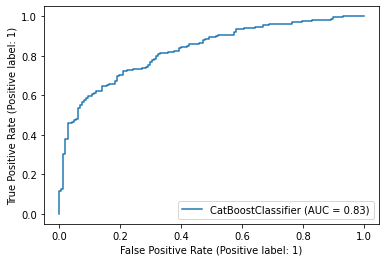

In [18]:
# Roc-кривая
plot_roc_curve(model, X_test, Y_test)

In [19]:
from sklearn.metrics import PrecisionRecallDisplay

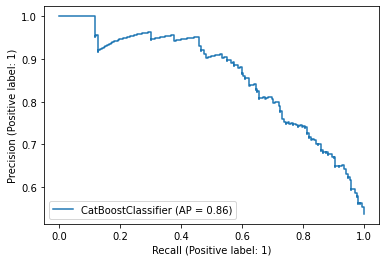

In [20]:
# PRC-кривая и PRC-AUC
PrecisionRecallDisplay.from_estimator(model, X_test, Y_test)

#### 2. Применить регрессию CatBoostRegressor к набору данных для регрессии. 

Вывести номер итерации и значения метрик (MAE и MSE) для наилучшей итерации. Обратите внимание, что в задаче восстановления регрессии целевая переменная имеет непрерывные значения.

In [21]:
model1 = CatBoostRegressor(
    custom_metric=["MAE", "RMSE"], 
    cat_features = cat_features
)

model1.fit(
    X_train, Y_train,
    eval_set=(X_test, Y_test),
    logging_level='Silent'
)

In [22]:
# лучшие параметры модели
print()
best_it = model1.get_best_iteration()
print('Best iteration: ' + str(best_it))
best_sc = model1.best_score_
print('Best score:'  + str(best_sc))


Best iteration: 395
Best score:{'learn': {'MAE': 0.13559388571396264, 'RMSE': 0.17147267802002228}, 'validation': {'MAE': 0.30613259420429895, 'RMSE': 0.3803683830934712}}


In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [50]:
# метрики качества регрессии
mae1 = mean_absolute_error(Y_test, model1.predict(X_test))
print('MAE: ', mae1)
mse1 = mean_squared_error(Y_test, model1.predict(X_test))
print('MSE: ', mse1)

MAE:  0.30866934223229714
MSE:  0.14468010685714155
